In [2]:
import pandas as pd
from pathlib import Path
import orjson
from geopy.distance import geodesic

# Data loading

### Main datasets
Loading of datasets, USA, India and Germany

In [3]:
# Use scientific notion
pd.set_option('display.float_format', '{:.2e}'.format)


df = pd.read_excel("India_data.xlsx")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
df2 = pd.read_csv("US_routes_1993_2024.csv", low_memory=False)
df2.head()

,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,...,8.14e+01,G4,1.00e+00,8.14e+01,G4,1.00e+00,8.14e+01,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,...,2.09e+02,DL,4.66e-01,2.20e+02,UA,1.19e-01,1.54e+02,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,...,1.85e+02,WN,9.97e-01,1.84e+02,WN,9.97e-01,1.84e+02,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,...,1.83e+02,AA,9.77e-01,1.83e+02,AA,9.77e-01,1.83e+02,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,...,1.77e+02,WN,6.06e-01,1.84e+02,AA,3.94e-01,1.66e+02,NaN,NaN,202131014014107ABQPHX


In [5]:
df3 = pd.read_csv("German_Air_fares.csv", low_memory=False)
df3.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,stops,price (€)
0,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:30am,7:45am,Eurowings,direct,74.00
1,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:40am,7:55am,easyJet,direct,75.00
2,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:45am,8:00am,easyJet,direct,80.00
3,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:15am,7:30am,Eurowings,direct,84.00
4,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:55am,8:10am,Eurowings,direct,84.00


### Supporting datasets
For augmenting the main one

In [6]:
from models import Airport

valid_airports = {}
try:
    file_path = Path("airline_routes.json")
    raw_data = file_path.read_bytes()
    data = orjson.loads(raw_data)

    total_airports = 0
    invalid_coords = 0

    for airport_code, airport_info in data.items():
        total_airports += 1

        if airport_info.get('latitude') is None or airport_info.get('longitude') is None:
            print(
                f"Invalid coordinates for airport {airport_code}: lat={airport_info.get('latitude')}, lon={airport_info.get('longitude')}")
            invalid_coords += 1
            continue

        try:
            float(airport_info['latitude'])
            float(airport_info['longitude'])
            valid_airports[airport_code] = Airport(**airport_info)
        except (ValueError, TypeError):
            print(
                f"Invalid coordinate format for airport {airport_code}: lat={airport_info['latitude']}, lon={airport_info['longitude']}")
            invalid_coords += 1
            continue

    print(f"Successfully loaded data for {len(valid_airports)} airports")
    print(f"Skipped {invalid_coords} airports with invalid coordinates out of {total_airports} total airports")
except Exception as e:
    print(f"Error loading airport data: {e}")
    raise

Invalid coordinates for airport KUB: lat=None, lon=None
Successfully loaded data for 3801 airports
Skipped 1 airports with invalid coordinates out of 3802 total airports


In [7]:
file_path = Path("airline_mapping.json")
raw_data = file_path.read_bytes()
airline_mapping = orjson.loads(raw_data)
print(f"Total number of airlines loaded: {len(airline_mapping)}")
print("First 10 airlines:")
print(dict(list(airline_mapping.items())[:10]))

Total number of airlines loaded: 593
First 10 airlines:
{'0B': 'Blue Air', '2A': 'Deutsche Bahn', '2I': '21 Air', '2J': 'Air Burkina', '2L': 'TAB', '2M': 'Maya Island Air', '2N': 'NextJet', '2O': 'Island Air Service', '2R': 'VIA Rail Canada', '2W': 'Welcome Air'}


# Data Cleanup and augmentation


Since I only have access to the dataset of 3 countries, namely USA, India and Germany. \
I look to engineer features that could be used for other regions, for e.g. using total distance traveled based on route, no. of stops etc.


### Transforming some columns into more usable forms in India dataset
- 1 stop, 2 stops → 1, 2
- 2h 30 min (duration) → 150 (total time in minutes)
- Region - new column
- Price - convert INR to USD
- total_distance new column, with calculated distances in meters
- Airline name to IATA codes

In [8]:
# Convert no. of stops to int
df = df.rename(columns={'Total_Stops': 'no_of_stops'})
stops_mapping = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}
df['no_of_stops'] = df['no_of_stops'].map(stops_mapping)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,no_of_stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0.00e+00,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2.00e+00,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2.00e+00,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1.00e+00,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1.00e+00,No info,13302


In [9]:
def duration_to_minutes(duration_str):
    parts = duration_str.split()
    total_minutes = 0
    for part in parts:
        if 'h' in part:
            total_minutes += int(part.replace('h', '')) * 60
        elif 'm' in part:
            total_minutes += int(part.replace('m', ''))
    return total_minutes


# Add duration_minutes for total duration in minutes
df['duration_minutes'] = df['Duration'].apply(duration_to_minutes)
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,no_of_stops,Additional_Info,Price,duration_minutes
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0.00e+00,No info,3897,170
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2.00e+00,No info,7662,445
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2.00e+00,No info,13882,1140
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1.00e+00,No info,6218,325
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1.00e+00,No info,13302,285


In [10]:
# total distance traveled
def calculate_total_distance(route):
    airports = route.split(' → ')
    total_distance = 0
    for i in range(len(airports) - 1):
        orig = valid_airports[airports[i]]
        dest = valid_airports[airports[i + 1]]
        orig_ll = (orig.latitude, orig.longitude)
        dest_ll = (dest.latitude, dest.longitude)
        total_distance += geodesic(orig_ll, dest_ll).meters
    return total_distance

# Add total_distance column
df['Route'] = df['Route'].astype(str)
df['total_distance'] = df['Route'].apply(calculate_total_distance)

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,no_of_stops,Additional_Info,Price,duration_minutes,total_distance
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0.00e+00,No info,3897,170,1.70e+06
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2.00e+00,No info,7662,445,1.84e+06
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2.00e+00,No info,13882,1140,2.66e+06
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1.00e+00,No info,6218,325,1.87e+06
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1.00e+00,No info,13302,285,1.74e+06


In [11]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df_usd_inr = pd.read_csv("rupee_vs_dollar.csv")
df_usd_inr = df_usd_inr.rename(columns={'year': 'Date', 'ind(Rs)': 'Price'})

df_usd_inr['Date'] = pd.to_datetime(df_usd_inr['Date'], format='%Y')

usd_inr_mapping = dict(zip(df_usd_inr['Date'].dt.year, df_usd_inr['Price']))

df['Date_of_Journey_Year'] = df['Date_of_Journey'].dt.year
df['Exchange_Rate'] = df['Date_of_Journey_Year'].map(usd_inr_mapping)
df['Price'] = df['Price'] / df['Exchange_Rate']

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,no_of_stops,Additional_Info,Price,duration_minutes,total_distance,Date_of_Journey_Year,Exchange_Rate
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0.00e+00,No info,5.54e+01,170,1.70e+06,2019,7.04e+01
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2.00e+00,No info,1.09e+02,445,1.84e+06,2019,7.04e+01
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2.00e+00,No info,1.97e+02,1140,2.66e+06,2019,7.04e+01
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1.00e+00,No info,8.83e+01,325,1.87e+06,2019,7.04e+01
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1.00e+00,No info,1.89e+02,285,1.74e+06,2019,7.04e+01


In [12]:
# Map Airline name to IATA code
df['Airline'] = df['Airline'].map({v: k for k, v in airline_mapping.items()})

# New col for the quarter of the year the trip happens
df['quarter'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y').dt.quarter

# Add new col to df. Region of data
df['Region'] = "South Asia"

# Drop unneeded fields
df = df.drop(columns=['Additional_Info', 'Date_of_Journey', 'Arrival_Time', 'Dep_Time', 'Duration', 'Route', 'Date_of_Journey_Year', 'Exchange_Rate'])

# Map
df['Price'] = df['Price'].astype(float)

df = df.dropna()

print(f"Total number of rows in the dataset: {len(df)}")

df.head()

Total number of rows in the dataset: 4622


,Airline,Source,Destination,no_of_stops,Price,duration_minutes,total_distance,quarter,Region
0,6E,Banglore,New Delhi,0.00e+00,5.54e+01,170,1.70e+06,1,South Asia
1,AI,Kolkata,Banglore,2.00e+00,1.09e+02,445,1.84e+06,2,South Asia
3,6E,Kolkata,Banglore,1.00e+00,8.83e+01,325,1.87e+06,2,South Asia
4,6E,Banglore,New Delhi,1.00e+00,1.89e+02,285,1.74e+06,1,South Asia
5,SG,Kolkata,Banglore,0.00e+00,5.50e+01,145,1.54e+06,2,South Asia


### Transforming some columns into more usable forms in US dataset
- no_of_stops - new column, 0.0 assuming all direct flights
- total_duration - new column, information, assuming direct flight, information taken from airline routes
- total_distance - new column, distance in meters, converted from miles
- Region
- Removing State from the city name

In [13]:
# Dropping useless columns
columns_to_keep = ['quarter', 'city1', 'city2', 'nsmiles', 'fare', 'carrier_lg', 'airport_1', "airport_2"]
df2 = df2[columns_to_keep]
df2.head()


,quarter,city1,city2,nsmiles,fare,carrier_lg,airport_1,airport_2
0,3,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",970,8.14e+01,G4,ABE,PIE
1,3,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",970,2.09e+02,DL,ABE,TPA
2,3,"Albuquerque, NM","Dallas/Fort Worth, TX",580,1.85e+02,WN,ABQ,DAL
3,3,"Albuquerque, NM","Dallas/Fort Worth, TX",580,1.83e+02,AA,ABQ,DFW
4,3,"Albuquerque, NM","Phoenix, AZ",328,1.77e+02,WN,ABQ,PHX


In [14]:
# Parse city1 and city2 to remove state/area mentions and keep only city names
def extract_city_name(city):
    return city.split(',')[0].strip()

df2['city1'] = df2['city1'].apply(extract_city_name)
df2['city2'] = df2['city2'].apply(extract_city_name)

# Add Region
df2['Region'] = "North America"

df2.head()

,quarter,city1,city2,nsmiles,fare,carrier_lg,airport_1,airport_2,Region
0,3,Allentown/Bethlehem/Easton,Tampa,970,8.14e+01,G4,ABE,PIE,North America
1,3,Allentown/Bethlehem/Easton,Tampa,970,2.09e+02,DL,ABE,TPA,North America
2,3,Albuquerque,Dallas/Fort Worth,580,1.85e+02,WN,ABQ,DAL,North America
3,3,Albuquerque,Dallas/Fort Worth,580,1.83e+02,AA,ABQ,DFW,North America
4,3,Albuquerque,Phoenix,328,1.77e+02,WN,ABQ,PHX,North America


In [15]:
from decimal import Decimal

df2['total_distance'] = df2['nsmiles'].apply(lambda x: float(Decimal(x) * Decimal('1609.34')))
df2.drop('nsmiles', axis=1, inplace=True)

df2.head()

,quarter,city1,city2,fare,carrier_lg,airport_1,airport_2,Region,total_distance
0,3,Allentown/Bethlehem/Easton,Tampa,8.14e+01,G4,ABE,PIE,North America,1.56e+06
1,3,Allentown/Bethlehem/Easton,Tampa,2.09e+02,DL,ABE,TPA,North America,1.56e+06
2,3,Albuquerque,Dallas/Fort Worth,1.85e+02,WN,ABQ,DAL,North America,9.33e+05
3,3,Albuquerque,Dallas/Fort Worth,1.83e+02,AA,ABQ,DFW,North America,9.33e+05
4,3,Albuquerque,Phoenix,1.77e+02,WN,ABQ,PHX,North America,5.28e+05


In [16]:
df2['no_of_stops'] = 0
df2.head()

,quarter,city1,city2,fare,carrier_lg,airport_1,airport_2,Region,total_distance,no_of_stops
0,3,Allentown/Bethlehem/Easton,Tampa,8.14e+01,G4,ABE,PIE,North America,1.56e+06,0
1,3,Allentown/Bethlehem/Easton,Tampa,2.09e+02,DL,ABE,TPA,North America,1.56e+06,0
2,3,Albuquerque,Dallas/Fort Worth,1.85e+02,WN,ABQ,DAL,North America,9.33e+05,0
3,3,Albuquerque,Dallas/Fort Worth,1.83e+02,AA,ABQ,DFW,North America,9.33e+05,0
4,3,Albuquerque,Phoenix,1.77e+02,WN,ABQ,PHX,North America,5.28e+05,0


In [17]:
def calculate_us_duration(airport_1: str, airport_2: str):
    if airport_1 in valid_airports and airport_2 in valid_airports:
        matching_route = next(
            (r for r in valid_airports[airport_1].routes if r.iata == airport_2), None
        )

        if matching_route:
            return matching_route.min

    return None


df2["duration_minutes"] = df2.apply(
    lambda row: calculate_us_duration(row["airport_1"], row["airport_2"]), axis=1
)

# Drop rows where duration could not be calculated
df2 = df2.dropna(subset=["duration_minutes"])
df2.head()

,quarter,city1,city2,fare,carrier_lg,airport_1,airport_2,Region,total_distance,no_of_stops,duration_minutes
0,3,Allentown/Bethlehem/Easton,Tampa,8.14e+01,G4,ABE,PIE,North America,1.56e+06,0,1.67e+02
2,3,Albuquerque,Dallas/Fort Worth,1.85e+02,WN,ABQ,DAL,North America,9.33e+05,0,1.05e+02
3,3,Albuquerque,Dallas/Fort Worth,1.83e+02,AA,ABQ,DFW,North America,9.33e+05,0,1.09e+02
4,3,Albuquerque,Phoenix,1.77e+02,WN,ABQ,PHX,North America,5.28e+05,0,8.50e+01
8,3,Albuquerque,Washington,2.56e+02,WN,ABQ,BWI,North America,2.69e+06,0,2.20e+02


In [18]:
# Renaming to match
df2.rename(columns={'fare': 'Price', 'carrier_lg': 'Airline', 'city1': "Source", 'city2': "Destination"}, inplace=True)
# Dropping columns
df2.drop(["airport_1", "airport_2"], axis=1, inplace=True)
df2.head()

,quarter,Source,Destination,Price,Airline,Region,total_distance,no_of_stops,duration_minutes
0,3,Allentown/Bethlehem/Easton,Tampa,8.14e+01,G4,North America,1.56e+06,0,1.67e+02
2,3,Albuquerque,Dallas/Fort Worth,1.85e+02,WN,North America,9.33e+05,0,1.05e+02
3,3,Albuquerque,Dallas/Fort Worth,1.83e+02,AA,North America,9.33e+05,0,1.09e+02
4,3,Albuquerque,Phoenix,1.77e+02,WN,North America,5.28e+05,0,8.50e+01
8,3,Albuquerque,Washington,2.56e+02,WN,North America,2.69e+06,0,2.20e+02


### Transforming some columns into more usable forms in Germany dataset
- no. of stops to numerical format
- Price to USD from euros
- Stripping of city name of Airport code
- Quarter field
- total duration field based on arrival and departure times

In [19]:
# Convert no. of stops to int
df3 = df3.rename(columns={'stops': 'no_of_stops'})
stops_mapping = {
    'direct': 0,
    '(1 stop)': 1,
    '(2 Stopps)': 2,
}
df3['no_of_stops'] = df3['no_of_stops'].map(stops_mapping)
df3.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price (€)
0,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:30am,7:45am,Eurowings,0.00e+00,74.00
1,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:40am,7:55am,easyJet,0.00e+00,75.00
2,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:45am,8:00am,easyJet,0.00e+00,80.00
3,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:15am,7:30am,Eurowings,0.00e+00,84.00
4,TXL Berlin-Tegel,DUS Düsseldorf,18.10.2019,25.10.2019,1 week,6:55am,8:10am,Eurowings,0.00e+00,84.00


In [20]:
# Extract airport code and remove it from city

df3 = df3.dropna(subset=['departure_city', 'arrival_city'])

df3[['src_airport', 'departure_city']] = df3['departure_city'].str.split(' ', n=1, expand=True)

df3[['dest_airport', 'arrival_city']] = df3['arrival_city'].str.split(' ', n=1, expand=True)

# Set Region as Europe
df3['Region'] = "Europe"

df3.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price (€),src_airport,dest_airport,Region
0,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:30am,7:45am,Eurowings,0.00e+00,74.00,TXL,DUS,Europe
1,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:40am,7:55am,easyJet,0.00e+00,75.00,TXL,DUS,Europe
2,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:45am,8:00am,easyJet,0.00e+00,80.00,TXL,DUS,Europe
3,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:15am,7:30am,Eurowings,0.00e+00,84.00,TXL,DUS,Europe
4,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:55am,8:10am,Eurowings,0.00e+00,84.00,TXL,DUS,Europe


In [21]:
from datetime import datetime

# Calculate total duration based on arrival and departure times
def calculate_duration_minutes(departure_date, departure_time, arrival_time):
    try:
        departure_time = departure_time.replace("Uhr", "").strip()
        arrival_time = arrival_time.replace("Uhr", "").strip()

        time_format = "%I:%M%p" if "am" in departure_time.lower() or "pm" in departure_time.lower() else "%H:%M"

        departure_datetime = datetime.strptime(f"{departure_date} {departure_time}", f"%d.%m.%Y {time_format}")
        arrival_datetime = datetime.strptime(f"{departure_date} {arrival_time}", f"%d.%m.%Y {time_format}")

        if arrival_datetime < departure_datetime:
            arrival_datetime += pd.Timedelta(days=1)

        duration = (arrival_datetime - departure_datetime).total_seconds() / 60
        return duration
    except Exception as e:
        print(f"Error calculating duration: {e}")
        return None

df3['duration_minutes'] = df3.apply(lambda row: calculate_duration_minutes(
    row['departure_date'], row['departure_time'], row['arrival_time']), axis=1)

df3.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price (€),src_airport,dest_airport,Region,duration_minutes
0,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:30am,7:45am,Eurowings,0.00e+00,74.00,TXL,DUS,Europe,7.50e+01
1,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:40am,7:55am,easyJet,0.00e+00,75.00,TXL,DUS,Europe,7.50e+01
2,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:45am,8:00am,easyJet,0.00e+00,80.00,TXL,DUS,Europe,7.50e+01
3,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:15am,7:30am,Eurowings,0.00e+00,84.00,TXL,DUS,Europe,7.50e+01
4,Berlin-Tegel,Düsseldorf,18.10.2019,25.10.2019,1 week,6:55am,8:10am,Eurowings,0.00e+00,84.00,TXL,DUS,Europe,7.50e+01


In [22]:
# Calculate the quarter from departure_date
df3['departure_date'] = pd.to_datetime(df3['departure_date'], dayfirst=True)
df3['quarter'] = df3['departure_date'].dt.quarter

df3.head()

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price (€),src_airport,dest_airport,Region,duration_minutes,quarter
0,Berlin-Tegel,Düsseldorf,18.10.2019,2019-10-25,1 week,6:30am,7:45am,Eurowings,0.00e+00,74.00,TXL,DUS,Europe,7.50e+01,4
1,Berlin-Tegel,Düsseldorf,18.10.2019,2019-10-25,1 week,6:40am,7:55am,easyJet,0.00e+00,75.00,TXL,DUS,Europe,7.50e+01,4
2,Berlin-Tegel,Düsseldorf,18.10.2019,2019-10-25,1 week,6:45am,8:00am,easyJet,0.00e+00,80.00,TXL,DUS,Europe,7.50e+01,4
3,Berlin-Tegel,Düsseldorf,18.10.2019,2019-10-25,1 week,6:15am,7:30am,Eurowings,0.00e+00,84.00,TXL,DUS,Europe,7.50e+01,4
4,Berlin-Tegel,Düsseldorf,18.10.2019,2019-10-25,1 week,6:55am,8:10am,Eurowings,0.00e+00,84.00,TXL,DUS,Europe,7.50e+01,4


In [23]:
import bisect

# Converting EUR to USD
# Using an algorithm to find the closest exchange rate on the scrape date

euro_to_usd_df = pd.read_csv("EURUSDX_update.csv")
euro_to_usd_df['Date'] = pd.to_datetime(euro_to_usd_df['Date'], format="%Y-%m-%d")

euro_to_usd_mapping = euro_to_usd_df.set_index('Date')['Close'].to_dict()
sorted_exchange_dates = sorted(euro_to_usd_mapping.keys())

df3['scrape_date'] = pd.to_datetime(df3['scrape_date'], format="%d.%m.%Y")

def get_closest_exchange_rate(scrape_date):
    if scrape_date in euro_to_usd_mapping:
        return euro_to_usd_mapping[scrape_date]
    pos = bisect.bisect_left(sorted_exchange_dates, scrape_date)
    if pos == 0:
        closest_date = sorted_exchange_dates[0]
    elif pos == len(sorted_exchange_dates):
        closest_date = sorted_exchange_dates[-1]
    else:
        before = sorted_exchange_dates[pos - 1]
        after = sorted_exchange_dates[pos]
        closest_date = before if (scrape_date - before) <= (after - scrape_date) else after
    return euro_to_usd_mapping[closest_date]

df3['exchange_rate'] = df3['scrape_date'].apply(get_closest_exchange_rate)

initial_length = len(df3)

df3 = df3.dropna(subset=['exchange_rate', 'price (€)'])

dropped_rows = initial_length - len(df3)
print(f"Number of rows dropped: {dropped_rows}")

df3 = df3.rename(columns={'price (€)': 'price_USD'})
df3['price_USD'] = df3['price_USD'].str.replace(',', '').astype(float) * df3['exchange_rate']

df3.head()

Number of rows dropped: 0


,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price_USD,src_airport,dest_airport,Region,duration_minutes,quarter,exchange_rate
0,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:30am,7:45am,Eurowings,0.00e+00,8.23e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00
1,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:40am,7:55am,easyJet,0.00e+00,8.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00
2,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:45am,8:00am,easyJet,0.00e+00,8.90e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00
3,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:15am,7:30am,Eurowings,0.00e+00,9.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00
4,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:55am,8:10am,Eurowings,0.00e+00,9.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00


In [24]:
from geopy.distance import geodesic

# TXL airport is now closed, using coords from Wikipedia

# Calculate total distance
def calculate_total_distance_germany(row):
    try:
        if row['src_airport'] == 'TXL':
            src_coords = (52.559722, 13.287778)
        elif row['src_airport'] in valid_airports:
            src_coords = (valid_airports[row['src_airport']].latitude, valid_airports[row['src_airport']].longitude)
        else:
            return None

        if row['dest_airport'] == 'TXL':
            dest_coords = (52.559722, 13.287778)
        elif row['dest_airport'] in valid_airports:
            dest_coords = (valid_airports[row['dest_airport']].latitude, valid_airports[row['dest_airport']].longitude)
        else:
            return None

        return geodesic(src_coords, dest_coords).meters
    except Exception as e:
        print(f"Error calculating distance for row: {e}")
    return None

df3['total_distance'] = df3.apply(calculate_total_distance_germany, axis=1)

initial_length = len(df3)
df3 = df3.dropna(subset=['total_distance'])
dropped_rows = initial_length - len(df3)

print(f"Number of rows dropped due to missing total_distance: {dropped_rows}")

df3.head()

Number of rows dropped due to missing total_distance: 0


,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price_USD,src_airport,dest_airport,Region,duration_minutes,quarter,exchange_rate,total_distance
0,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:30am,7:45am,Eurowings,0.00e+00,8.23e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05
1,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:40am,7:55am,easyJet,0.00e+00,8.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05
2,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:45am,8:00am,easyJet,0.00e+00,8.90e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05
3,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:15am,7:30am,Eurowings,0.00e+00,9.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05
4,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:55am,8:10am,Eurowings,0.00e+00,9.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05


In [25]:
# Dropped Multiple airlines, unknown airlines

df3 = df3[~df3["airline"].isin(["Multiple Airlines", "Mehrere Fluglinien"])]


airline_mapping_dict = {value: key for key, value in airline_mapping.items()}

# Custom names, because data is strange
airline_mapping_dict["LOT-Polish Airlines"] = airline_mapping_dict["LOT - Polish Airlines"]
airline_mapping_dict["Swiss International Air Lines"] = airline_mapping_dict["SWISS"]
airline_mapping_dict["Austrian Airlines"] = airline_mapping_dict["Austrian"]
airline_mapping_dict["Flybe"] = "BE"
airline_mapping_dict["Alitalia"] = "AZ"
airline_mapping_dict["SAS"] = "SK"

df3["airline_code"] = df3["airline"].map(airline_mapping_dict)

# Drop rows with NA airlines
initial_length = len(df3)
df3 = df3.dropna(subset=["airline"])
dropped_airlines = initial_length - len(df3)

print(f"Number of rows dropped due to NA airlines: {dropped_airlines}")
df3.head()

Number of rows dropped due to NA airlines: 0


,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,no_of_stops,price_USD,src_airport,dest_airport,Region,duration_minutes,quarter,exchange_rate,total_distance,airline_code
0,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:30am,7:45am,Eurowings,0.00e+00,8.23e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05,EW
1,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:40am,7:55am,easyJet,0.00e+00,8.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05,U2
2,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:45am,8:00am,easyJet,0.00e+00,8.90e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05,U2
3,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:15am,7:30am,Eurowings,0.00e+00,9.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05,EW
4,Berlin-Tegel,Düsseldorf,2019-10-18,2019-10-25,1 week,6:55am,8:10am,Eurowings,0.00e+00,9.35e+01,TXL,DUS,Europe,7.50e+01,4,1.11e+00,4.71e+05,EW


In [26]:
# Renaming columns and dropping useless ones

# Renaming to match
df3.rename(columns={
    'price_USD': 'Price',
    'departure_city': 'Source',
    'arrival_city': 'Destination',
    'airline_code': 'Airline'
}, inplace=True)

# Dropping unnecessary columns
columns_to_drop = ['src_airport', 'dest_airport', 'scrape_date', 'departure_date',
                   'departure_date_distance', 'departure_time', 'arrival_time', 'airline', 'exchange_rate']
df3.drop(columns=columns_to_drop, axis=1, inplace=True)

df3.head()

,Source,Destination,no_of_stops,Price,Region,duration_minutes,quarter,total_distance,Airline
0,Berlin-Tegel,Düsseldorf,0.00e+00,8.23e+01,Europe,7.50e+01,4,4.71e+05,EW
1,Berlin-Tegel,Düsseldorf,0.00e+00,8.35e+01,Europe,7.50e+01,4,4.71e+05,U2
2,Berlin-Tegel,Düsseldorf,0.00e+00,8.90e+01,Europe,7.50e+01,4,4.71e+05,U2
3,Berlin-Tegel,Düsseldorf,0.00e+00,9.35e+01,Europe,7.50e+01,4,4.71e+05,EW
4,Berlin-Tegel,Düsseldorf,0.00e+00,9.35e+01,Europe,7.50e+01,4,4.71e+05,EW


In [27]:
# Combining datasets
df_combined = pd.concat([df, df2, df3], axis=0, ignore_index=True)

df_combined.reset_index(drop=True, inplace=True)

total_records = len(df_combined)
print(f"Total number of records: {total_records}")

df_combined.head()

Total number of records: 214166


,Airline,Source,Destination,no_of_stops,Price,duration_minutes,total_distance,quarter,Region
0,6E,Banglore,New Delhi,0.00e+00,5.54e+01,1.70e+02,1.70e+06,1,South Asia
1,AI,Kolkata,Banglore,2.00e+00,1.09e+02,4.45e+02,1.84e+06,2,South Asia
2,6E,Kolkata,Banglore,1.00e+00,8.83e+01,3.25e+02,1.87e+06,2,South Asia
3,6E,Banglore,New Delhi,1.00e+00,1.89e+02,2.85e+02,1.74e+06,1,South Asia
4,SG,Kolkata,Banglore,0.00e+00,5.50e+01,1.45e+02,1.54e+06,2,South Asia


# Handling data, encoding

Retrieve categorical value

In [28]:
column=[column for column in df_combined.columns if df_combined[column].dtype=='object']
column

['Airline', 'Source', 'Destination', 'Region']

Retrieve continuous values

In [29]:
continuous_col =[column for column in df_combined.columns if df_combined[column].dtype!='object']
continuous_col

['no_of_stops', 'Price', 'duration_minutes', 'total_distance', 'quarter']

### Handing Categorical data

Nominal data,
- High cardinality Cities using TargetEncoder
- Airline using One hot


In [30]:
categorical = df_combined[column]
categorical.head()


,Airline,Source,Destination,Region
0,6E,Banglore,New Delhi,South Asia
1,AI,Kolkata,Banglore,South Asia
2,6E,Kolkata,Banglore,South Asia
3,6E,Banglore,New Delhi,South Asia
4,SG,Kolkata,Banglore,South Asia


In [31]:
df_airlines = pd.get_dummies(df_combined['Airline'], prefix='airline', drop_first=True)
df_airlines.head()

,airline_5J,airline_6E,airline_9K,airline_9N,airline_AA,airline_AF,airline_AI,airline_AS,airline_AZ,airline_B6,...,airline_W9,airline_WN,airline_WV,airline_XP,airline_YV,airline_YX,airline_YY,airline_ZA,airline_ZV,airline_ZW
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
df_regions = pd.get_dummies(df_combined['Region'], prefix='region', drop_first=True)
df_regions.head()

,region_North America,region_South Asia
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [33]:
from sklearn.preprocessing import TargetEncoder
import joblib
# Target price, variable we are trying to predict


source_encoder = TargetEncoder()
dest_encoder = TargetEncoder()
df_combined["source_encoded"] = source_encoder.fit_transform(df_combined[["Source"]], df_combined["Price"])
df_combined["dest_encoded"] = dest_encoder.fit_transform(df_combined[["Destination"]], df_combined["Price"])

# Save the encoders
joblib.dump(source_encoder, "source_encoder.joblib")
joblib.dump(dest_encoder, "dest_encoder.joblib")


print("Target-Encoded Source Cities:")
print(df_combined[['Source', 'source_encoded']].head())

print("\nTarget-Encoded Destination Cities:")
print(df_combined[['Destination', 'dest_encoded']].head())

Target-Encoded Source Cities:
     Source  source_encoded
0  Banglore        9.31e+01
1   Kolkata        1.00e+02
2   Kolkata        1.00e+02
3  Banglore        9.12e+01
4   Kolkata        1.00e+02

Target-Encoded Destination Cities:
  Destination  dest_encoded
0   New Delhi      1.31e+02
1    Banglore      1.00e+02
2    Banglore      1.02e+02
3   New Delhi      1.28e+02
4    Banglore      1.01e+02


In [34]:
# Concat encoded airline and region back in
df_combined = pd.concat([df_combined, df_airlines, df_regions], axis=1)
df_combined = df_combined.drop(["Airline", "Source", "Destination", "Region"], axis=1)

df_combined.head()

,no_of_stops,Price,duration_minutes,total_distance,quarter,source_encoded,dest_encoded,airline_5J,airline_6E,airline_9K,...,airline_WV,airline_XP,airline_YV,airline_YX,airline_YY,airline_ZA,airline_ZV,airline_ZW,region_North America,region_South Asia
0,0.00e+00,5.54e+01,1.70e+02,1.70e+06,1,9.31e+01,1.31e+02,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,2.00e+00,1.09e+02,4.45e+02,1.84e+06,2,1.00e+02,1.00e+02,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1.00e+00,8.83e+01,3.25e+02,1.87e+06,2,1.00e+02,1.02e+02,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,1.00e+00,1.89e+02,2.85e+02,1.74e+06,1,9.12e+01,1.28e+02,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0.00e+00,5.50e+01,1.45e+02,1.54e+06,2,1.00e+02,1.01e+02,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Feature selection

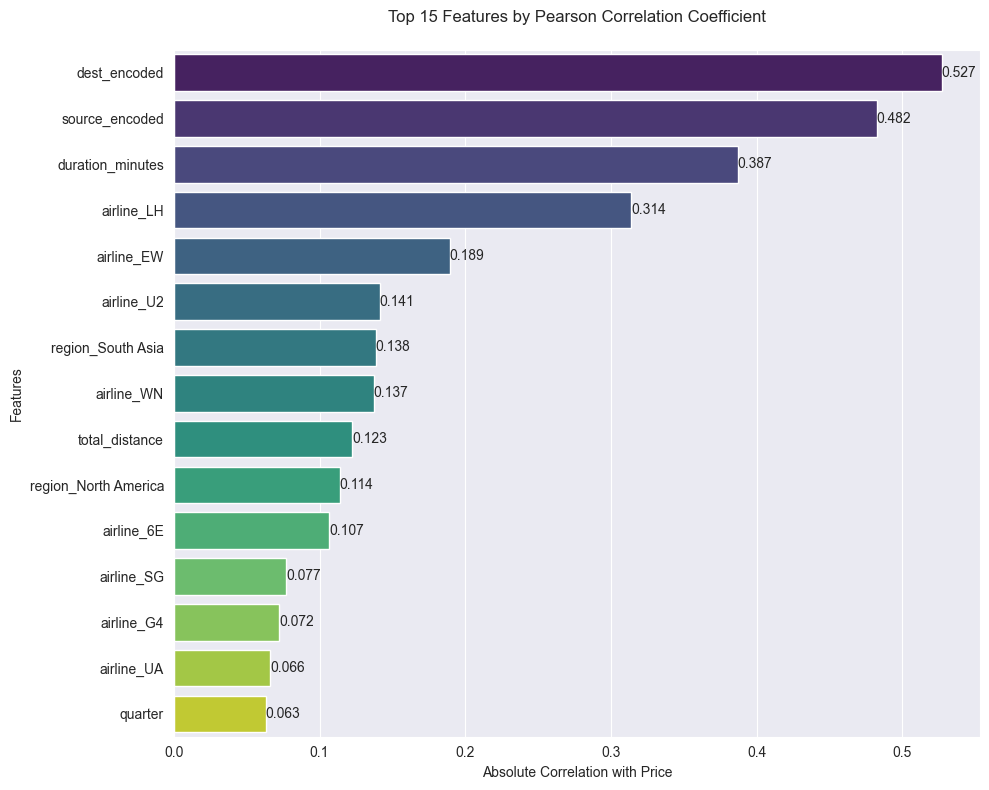

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Work with pandas instead of cudf
X = df_combined.drop('Price', axis=1)
y = df_combined['Price']

feature_importance = pd.Series(np.zeros(len(X.columns)), index=X.columns)

for col in X.columns:
    # Calculate absolute correlation (direction doesn't matter for importance) using numpy
    corr = abs(np.corrcoef(X[col].to_numpy(), y.to_numpy())[0, 1])
    feature_importance[col] = corr

importance_series = feature_importance.sort_values(ascending=False)

# Get top 15 features
top_15_features = importance_series.head(15)

top_15_values = top_15_features.values
top_15_index = top_15_features.index

# Plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=top_15_values,
                 y=top_15_index,
                 hue=top_15_index,
                 palette='viridis')

for i, v in enumerate(top_15_values):
    ax.text(v, i, f'{v:.3f}', va='center')

plt.title('Top 15 Features by Pearson Correlation Coefficient', pad=20)
plt.xlabel('Absolute Correlation with Price')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

I decided to filter out airlines here because my dataset does not comprise of all airline companies in the world, so it doesn't make sense to have it be one of the variables in the model. \
It could introduce bias and inaccuracies
However, it should be noted that if the airlines are properly categorised as budget, premium, etc.
and flights are categorised as domestic/international
The airline feature could be more useful


In [36]:
# Dropping unimportant features
top_15_features_list = top_15_index.tolist()

# Filter out airline features
top_15_features_list = [feat for feat in top_15_features_list if 'airline_' not in feat]

X_selected = X[top_15_features_list]
top_15_features_list

['dest_encoded',
 'source_encoded',
 'duration_minutes',
 'region_South Asia',
 'total_distance',
 'region_North America',
 'quarter']

# Data modelling

We will first be testing multiple models and picking the best one

- Linear regression cause why not, likely will not capture the complex relationships between variables for flight pricing
- Random forest, there's a published study that uses this
- Scikit Gradient Boosting
- XGBoost (another gradient boosting)

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

### Linear regression

In [178]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.fit(X_train, y_train).predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression - MAE: ${mae:.2f}, R²: {r2:.4f}")

Linear Regression - MAE: $56.89, R²: 0.5443


### Random Forest

In [179]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MAE: ${mae_rf:.2f}, R²: {r2_rf:.4f}")

Random Forest - MAE: $38.85, R²: 0.7697


### Gradient Boosting

In [180]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting - MAE: ${mae_gb:.2f}, R²: {r2_gb:.4f}")


Gradient Boosting - MAE: $46.24, R²: 0.7235


### XGBoost

In [181]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: ${mae_xgb:.2f}, R²: {r2_xgb:.4f}")


XGBoost - MAE: $38.25, R²: 0.7927


From the results, XGBoost is the best model
with the lowest Mean absolute error and the highest R squared \
We will save the model in a json format for future use

In [182]:
xgb_model.save_model('flight_price_model.json')